In [31]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Dropout,Conv2DTranspose, UpSampling2D, concatenate
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report

# # Establecer el dispositivo GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Cambiar "0" por el número de tu GPU
#
# # Restringir el crecimiento de la memoria de la GPU para evitar que ocupe toda la memoria
# physical_devices = tf.config.list_physical_devices("GPU")
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)


# Paso 1: Cargar los datos
data_folder = "./Dataset"
image_folder = os.path.join(data_folder, "train_images_256")
mask_folder = os.path.join(data_folder, "train_masks_256")

# Obtener lista de nombres de archivo para las imágenes
image_files = os.listdir(image_folder)

In [26]:
print("TensorFlow version:", tf.__version__)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"




TensorFlow version: 2.13.0


In [36]:

# Paso 2: Preparar los datos
# Redimensionar todas las imágenes a un tamaño específico
image_size = (256, 256)

# Crear listas para almacenar las imágenes y sus máscaras
images = []
masks = []

# cargar imagenes y mascaras
for filename in image_files:
    image_path = os.path.join(image_folder, filename)
    mask_path = os.path.join(mask_folder, filename)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # image = cv2.resize(image, image_size)
    # mask = cv2.resize(mask, image_size)

    # Normalizar las imágenes y máscaras para que los valores estén entre 0 y 1
    image = image / 255.0
    mask = mask / 255.0

    # Cambiar los píxeles en la máscara mayores que 0 a 255
    # mask[mask > 0] = 255

    images.append(image)
    masks.append(mask)


# Convertir las listas de imágenes y máscaras a arreglos numpy
images = np.array(images)
masks = np.array(masks)

# Agregar una dimensión adicional para el canal (ya que las imágenes están en escala de grises)
images = np.expand_dims(images, axis=-1)
masks = np.expand_dims(masks, axis=-1)




In [37]:
image_files = os.listdir(image_folder)
half_length = len(image_files) // 4
image_files = image_files[:half_length]

print(len(image_files))

197


In [29]:
print(image_size + (1,))

(256, 256, 1)


In [38]:


# Paso 3: Implementar el modelo U-Net

def unet(input_layer=(256, 256, 1), start_neurons=16):
    inputs = Input(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    model = Model(inputs=inputs, outputs=output_layer)
    
    return model

# input_layer = Input((img_size_target, img_size_target, 1))
# output_layer = build_model(input_layer, 16)



# Paso 4: Compilar y entrenar el modelo
model = unet(input_layer=(256,256,1), start_neurons=16)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(images, masks, batch_size=8, epochs=5, validation_split=0.2)

Epoch 1/5
79/79 [==============================] - 86s 1s/step - loss: 0.0386 - accuracy: 0.9814 - val_loss: 0.0150 - val_accuracy: 0.9836
Epoch 2/5
79/79 [==============================] - 84s 1s/step - loss: 0.0024 - accuracy: 0.9815 - val_loss: 0.0045 - val_accuracy: 0.9836
Epoch 3/5
79/79 [==============================] - 84s 1s/step - loss: 0.0020 - accuracy: 0.9815 - val_loss: 0.0047 - val_accuracy: 0.9836
Epoch 4/5
79/79 [==============================] - 84s 1s/step - loss: 0.0019 - accuracy: 0.9815 - val_loss: 0.0080 - val_accuracy: 0.9836
Epoch 5/5
79/79 [==============================] - 84s 1s/step - loss: 0.0019 - accuracy: 0.9815 - val_loss: 0.0040 - val_accuracy: 0.9836


1/1 [==============================] - 0s 39ms/step


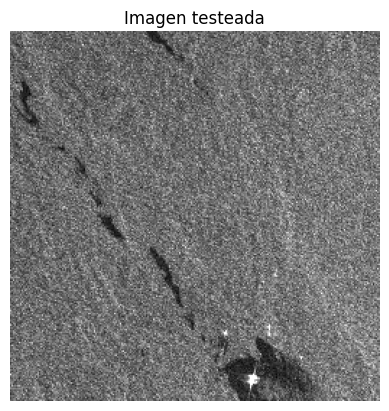

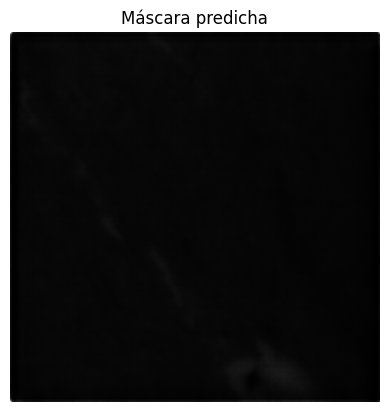

In [42]:
# Paso 5: Usar el modelo para predecir
# Aquí puedes cargar una nueva imagen en escala de grises, redimensionarla y normalizarla de la misma manera que en el paso 2.
# Luego, utiliza el modelo entrenado para hacer una predicción en la imagen y obtener la máscara resultante.

# ejemplo de predicción
test_image = cv2.imread("./Dataset/train_images_256/041871.000163.tif", cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, image_size)
test_image = test_image.astype('float32') / 255.0
test_image = np.expand_dims(test_image, axis=0)
test_image = np.expand_dims(test_image, axis=-1)

predicted_mask = model.predict(test_image)


# Mostrar la imagen testeada
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Imagen testeada')
plt.axis('off')
plt.show()


# Mostrar la máscara predicha
predicted_mask = predicted_mask.squeeze()
plt.imshow(predicted_mask, cmap='gray')
plt.title('Máscara predicha')
plt.axis('off')
plt.show()